## Import Libraries and Dataset

In [1]:
# !pip install statsmodels
# !pip install pyts

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.2 MB/s eta 0:00:00


In [2]:
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Time-Series Analysis Libraries
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# LSTNet Required Libraries
from tensorflow.keras.layers import MultiHeadAttention

from pyts.image import GramianAngularField

In [3]:
# Downloading Electricity Dataset (RUN THIS ONCE THEN UNCOMMENT)
# !wget https://github.com/laiguokun/multivariate-time-series-data/raw/master/electricity/electricity.txt.gz
# !gzip -d electricity.txt.gz

--2023-04-05 12:32:01--  https://github.com/laiguokun/multivariate-time-series-data/raw/master/electricity/electricity.txt.gz
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/laiguokun/multivariate-time-series-data/master/electricity/electricity.txt.gz [following]
--2023-04-05 12:32:01--  https://raw.githubusercontent.com/laiguokun/multivariate-time-series-data/master/electricity/electricity.txt.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17993794 (17M) [application/octet-stream]
Saving to: ‘electricity.txt.gz’

electricity.txt.gz  100%[===================>]  17.16M  --.-KB/s    in 0.1s   

## Train-Test Split

In [4]:
# Load dataset
dataset = pd.read_csv('electricity.txt', header=None)
print(dataset.shape) # check dimensions
display(dataset.head())

(26304, 321)


,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0


In [5]:
# Univariate Time Series Analysis
single_series = dataset.iloc[:, 3]

# Create a datetime index
date_rng = pd.date_range(start='2012-01-01', freq='H', periods=len(single_series))
single_series.index = date_rng

# Extract the time and series components
series = single_series.to_numpy()
#time = single_series.index.to_numpy()
time = np.arange(0, len(series))

In [6]:
# Parameters
window_size = 24*7 #  model will use the past week's worth of data (24 hours*7 days = 168) to make predictions.
batch_size = 16
shuffle_buffer_size = 1000
stride = 24 # number of skips used as the sampling window slides across the entire dataset.

In [7]:
# 80-20 split for training-validation
num_train = int(len(series) * 0.8 / stride) * stride
split_time = int(num_train)

# Get the training and validation set 
time_train = time[:split_time]
series_train = series[:split_time]
time_valid = time[split_time:]
series_valid = series[split_time:]

## Generating Windowed Dataset

In [8]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer, stride):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size (number of time windows that are processed in each iteration of training)
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """
    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)
    
    # Window the data but only take those with the specified size (note stride argument)
    dataset = dataset.window(window_size + 1, shift=stride, drop_remainder=True)
    
    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    
    # Create tuples with features and labels 
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))

    # Shuffle the windows
    dataset = dataset.shuffle(shuffle_buffer)
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [9]:
stride = 1
batch_size = 32
dataset_windowed = windowed_dataset(series_train, window_size, batch_size, shuffle_buffer_size, stride)

In [10]:
# Print properties of a single batch
print("Properties of a single batch:")
print("------------------------------")
for windows in dataset_windowed.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}') # (batch_size, window_size)
  print(f'shape of second element: {windows[1].shape}') # (batch_size, )

Properties of a single batch:
------------------------------
data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 168)
shape of second element: (32,)


In [11]:
total_elements = 0
for _ in dataset_windowed:
    total_elements += 1
print("Total elements in the dataset:", total_elements)

Total elements in the dataset: 652


## Implementation of Skip-GRU Layer

In [12]:
class SkipGRU(tf.keras.layers.Layer):

    def __init__(self,
                 units,
                 p=1,
                 activation='relu',
                 return_sequences=False,
                 return_state=False,
                 **kwargs):

        '''
        Recurrent-skip layer, see Section 3.4 in the LSTNet paper.
        
        Parameters:
        __________________________________
        units: int.
            Number of hidden units of the GRU cell.

        p: int.
            Number of skipped hidden cells.

        activation: str, function.
            Activation function, see https://www.tensorflow.org/api_docs/python/tf/keras/activations.

        return_sequences: bool.
            Whether to return the last output or the full sequence.

        return_state: bool.
            Whether to return the last state in addition to the output.

        **kwargs: See https://www.tensorflow.org/api_docs/python/tf/keras/layers/GRUCell.
        '''

        if p < 1:
            raise ValueError('The number of skipped hidden cells cannot be less than 1.')

        self.units = units
        self.p = p
        self.return_sequences = return_sequences
        self.return_state = return_state
        self.timesteps = None
        self.cell = tf.keras.layers.GRUCell(units=units, activation=activation, **kwargs)

        super(SkipGRU, self).__init__()

    def build(self, input_shape):

        if self.timesteps is None:
            self.timesteps = input_shape[1]

            if self.p > self.timesteps:
                raise ValueError('The number of skipped hidden cells cannot be greater than the number of timesteps.')

    def call(self, inputs):

        '''
        Parameters:
        __________________________________
        inputs: tf.Tensor.
            Layer inputs, 2-dimensional tensor with shape (n_samples, filters) where n_samples is the batch size
            and filters is the number of channels of the convolutional layer.

        Returns:
        __________________________________
        outputs: tf.Tensor.
            Layer outputs, 2-dimensional tensor with shape (n_samples, units) if return_sequences == False,
            3-dimensional tensor with shape (n_samples, n_lookback, units) if return_sequences == True where
            n_samples is the batch size, n_lookback is the number of past time steps used as input and units
            is the number of hidden units of the GRU cell.

        states: tf.Tensor.
            Hidden states, 2-dimensional tensor with shape (n_samples, units) where n_samples is the batch size
            and units is the number of hidden units of the GRU cell.
        '''

        outputs = tf.TensorArray(
            element_shape=(inputs.shape[0], self.units),
            size=self.timesteps,
            dynamic_size=False,
            dtype=tf.float32,
            clear_after_read=False
        )

        states = tf.TensorArray(
            element_shape=(inputs.shape[0], self.units),
            size=self.timesteps,
            dynamic_size=False,
            dtype=tf.float32,
            clear_after_read=False
        )

        initial_states = tf.zeros(
            shape=(tf.shape(inputs)[0], self.units),
            dtype=tf.float32
        )

        for t in tf.range(self.timesteps):

            if t < self.p:
                output, state = self.cell(
                    inputs=inputs[:, t, :],
                    states=initial_states
                )

            else:
                output, state = self.cell(
                    inputs=inputs[:, t, :],
                    states=states.read(t - self.p)
                )

            outputs = outputs.write(index=t, value=output)
            states = states.write(index=t, value=state)

        outputs = tf.transpose(outputs.stack(), [1, 0, 2])
        states = tf.transpose(states.stack(), [1, 0, 2])

        if not self.return_sequences:
            outputs = outputs[:, -1, :]

        if self.return_state:
            states = states[:, -1, :]
            return outputs, states

        else:
            return outputs

## Kernal Regularizer

In [13]:
def kernel_regularizer(regularizer, regularization_factor):

    '''
    Parameters:
    __________________________________
    regularizer: str.
        Regularizer, either 'L1', 'L2' or 'L1L2'.

    regularization_factor: float.
        Regularization factor.
    '''
    
    if regularizer == 'L1':
        return tf.keras.regularizers.L1(l1=regularization_factor)

    elif regularizer == 'L2':
        return tf.keras.regularizers.L2(l2=regularization_factor)

    elif regularizer == 'L1L2':
        return tf.keras.regularizers.L1L2(l1=regularization_factor, l2=regularization_factor)

    else:
        raise ValueError('Undefined regularizer {}.'.format(regularizer))

## LSTNet Main Architecture

In [14]:
def build_fn(n_targets, # Number of time series. (int)
             n_lookback, # Number of past time steps to use as input. (int)
             filters, # Number of filters (or channels) of the convolutional layer. (int)
             kernel_size, # Kernel size of the convolutional layer. (int)
             gru_units, # Hidden units of GRU layer. (list)
             skip_gru_units, # Hidden units of Skip GRU layer. (list)
             skip, # Number of skipped hidden cells in the Skip GRU layer. (int)
             lags, # Number of autoregressive lags. (int)
             num_heads, # Number of attention heads. (int) <---- NEW!
             dropout, # Dropout rate. (float)
             regularizer, # Regularizer, either 'L1', 'L2' or 'L1L2'. (str)
             regularization_factor): # Regularization factor. (float)

    # Inputs.
    x = tf.keras.layers.Input(shape=(n_lookback, n_targets))

    # Convolutional component, see Section 3.2 in the LSTNet paper.
    c = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
    c = tf.keras.layers.Dropout(rate=dropout)(c)

    # Recurrent component, see Section 3.3 in the LSTNet paper.
    r = tf.keras.layers.GRU(units=gru_units, activation='relu', return_sequences=True)(c)
    
    # Attention Mechanism, see Section 3.5 in the LSTNet paper. <---- NEW!
    r = MultiHeadAttention(num_heads=num_heads, key_dim=gru_units)(r, r)
    r = tf.keras.layers.Flatten()(r)
    r = tf.keras.layers.Dropout(rate=dropout)(r)
    
    # Recurrent-skip component, see Section 3.4 in the LSTNet paper.
    s = SkipGRU(units=skip_gru_units, activation='relu', return_sequences=True)(c)
    s = tf.keras.layers.Dropout(rate=dropout)(s)
    s = tf.keras.layers.Lambda(function=lambda x: x[:, - skip:, :])(s)
    s = tf.keras.layers.Reshape(target_shape=(s.shape[1] * s.shape[2],))(s)
    d = tf.keras.layers.Concatenate(axis=1)([r, s])
    d = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(d)

    # Autoregressive component, see Section 3.6 in the LSTNet paper.
    l = tf.keras.layers.Flatten()(x[:, - lags:, :])
    l = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(l)

    # Outputs.
    y = tf.keras.layers.Add()([d, l])

    return tf.keras.models.Model(x, y)

## LSTNet Training Parameters

In [15]:
# Build and save LSTNet Model
model = build_fn(
    n_targets = 1, # univariate time series test
    n_lookback = window_size,
    filters = 64,
    kernel_size = 3,
    gru_units = 100,
    skip_gru_units = 50,
    skip = 1,
    lags = 1,
    num_heads = 2,
    dropout = 0,
    regularizer = 'L2',
    regularization_factor = 0.01)

In [16]:
# Set the learning rate
learning_rate = 7.0795e-04 # optimal from Tuning Process (loss minimized)

# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Adam optimizer appears to run quite slowly
# optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [17]:
# Train the model
history = model.fit(dataset_windowed,epochs=5)

Epoch 1/5
652/652 [==============================] - 392s 565ms/step - loss: 94.6780 - mae: 95.1380
Epoch 2/5
652/652 [==============================] - 355s 545ms/step - loss: 36.2891 - mae: 36.7470
Epoch 3/5
652/652 [==============================] - 359s 550ms/step - loss: 33.6801 - mae: 34.1387
Epoch 4/5
652/652 [==============================] - 355s 544ms/step - loss: 33.7498 - mae: 34.2089
Epoch 5/5
652/652 [==============================] - 352s 539ms/step - loss: 33.3079 - mae: 33.7675


## LSTNet Recursive Forecast

In [18]:
def model_forecast(model, series, window_size, shift):  
    # Generate TF Dataset from series values
    ds = tf.data.Dataset.from_tensor_slices(series)
    # Window the data
    ds = ds.window(window_size, shift=shift, drop_remainder=True)
    # Flatten windows by putting elements in a single batch
    ds = ds.flat_map(lambda w: w.batch(window_size))
    # Create batches of windows
    ds = ds.batch(32).prefetch(1)
    # Get predictions on the entire dataset
    forecast = model.predict(ds,verbose=0)
    return forecast
def recursive_forecast(model, series, window_size, stride, hsteps):
  window = series[-window_size:]
  forecast = []
  for h in range(hsteps):
    nextstep = model_forecast(model, window, window_size, stride).squeeze()
    window = np.append(window,nextstep) #add next step to window
    window = np.delete(window,0) #delete first step of window
    forecast = np.append(forecast,nextstep)
  return forecast     

In [ ]:
recursive = recursive_forecast(model, series_train, window_size, stride, len(series_valid)) # 11min
np.save('recursive_result', recursive)

In [20]:
recursive = np.load('recursive_result.npy')

# Absolute Error vs Time
recursive_absErr = abs(np.subtract(recursive,series_valid))

# Mean Absolute Error vs Time
recursive_mae = np.asarray([ recursive_absErr[0] , (recursive_absErr[0]+recursive_absErr[1])/2 ])
for i in range(len(recursive_absErr)-2):
  CummErr = recursive_mae[-1]*(i+1) 
  mae = (CummErr + recursive_absErr[i+1]) / (i+2)
  recursive_mae = np.append(recursive_mae,mae)

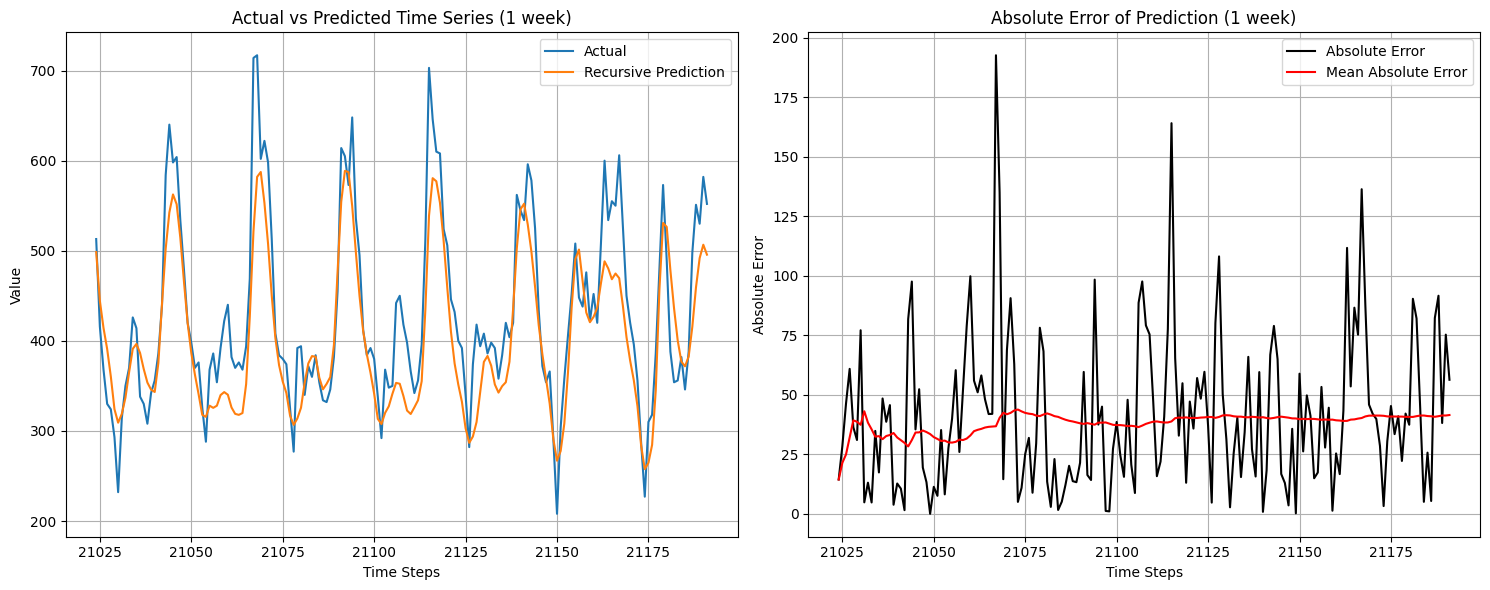

In [33]:
dts = window_size*1 # max timestep to plot until 
# dts = len(series_valid)

fig, axs = plt.subplots(1, 2, sharey=False, figsize=(15,6))
axs[0].title.set_text('Actual vs Predicted Time Series (1 week)')
axs[0].set_ylabel('Value'); axs[0].set_xlabel('Time Steps')
axs[0].plot(time_valid[0:dts], series_valid[0:dts], label="Actual")
axs[0].plot(time_valid[0:dts], recursive[0:dts], label="Recursive Prediction")
axs[0].legend(); axs[0].grid()

axs[1].title.set_text('Absolute Error of Prediction (1 week)')
axs[1].set_ylabel('Absolute Error'); axs[1].set_xlabel('Time Steps')
axs[1].plot(time_valid[0:dts], recursive_absErr[0:dts], 'k', label="Absolute Error")
axs[1].plot(time_valid[0:dts], recursive_mae[0:dts], 'r', label="Mean Absolute Error")
axs[1].legend(); axs[1].grid()

fig.tight_layout()

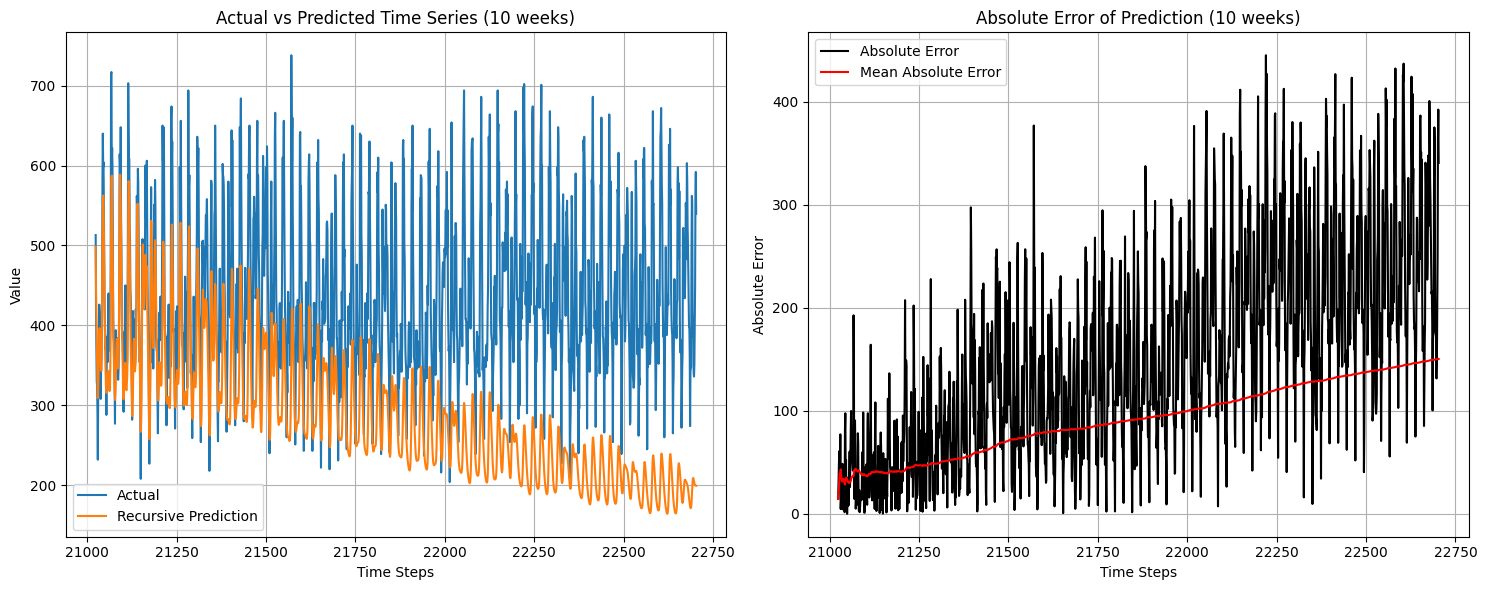

In [37]:
dts = window_size*10 # max timestep to plot until 
# dts = len(series_valid)

fig, axs = plt.subplots(1, 2, sharey=False, figsize=(15,6))
axs[0].title.set_text('Actual vs Predicted Time Series (10 weeks)')
axs[0].set_ylabel('Value'); axs[0].set_xlabel('Time Steps')
axs[0].plot(time_valid[0:dts], series_valid[0:dts], label="Actual")
axs[0].plot(time_valid[0:dts], recursive[0:dts], label="Recursive Prediction")
axs[0].legend(); axs[0].grid()

axs[1].title.set_text('Absolute Error of Prediction (10 weeks)')
axs[1].set_ylabel('Absolute Error'); axs[1].set_xlabel('Time Steps')
axs[1].plot(time_valid[0:dts], recursive_absErr[0:dts], 'k', label="Absolute Error")
axs[1].plot(time_valid[0:dts], recursive_mae[0:dts], 'r', label="Mean Absolute Error")
axs[1].legend(); axs[1].grid()

fig.tight_layout()

## LSTNet Rectify Forecast

In [23]:
num_windows = int((split_time-window_size*2)/stride)
window = series_train[0:window_size]
forecast_train = []
for i in tqdm(range(1,num_windows)):
  value = recursive_forecast(model, window, window_size, stride, stride)
  forecast_train = np.append(forecast_train,value)
  window = series_train[ stride*i+window_size : stride*i+window_size*2]

100%|██████████| 20687/20687 [38:25<00:00,  8.97it/s]


In [24]:
actual_train = series_train[window_size:len(forecast_train)+window_size]
actual_train_time = time_train[window_size:len(forecast_train)+window_size]
error_train = actual_train - forecast_train
actual_train = series_train[0:len(forecast_train)]

In [25]:
def windowed_generator_error(series, window_size, stride, error_series):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=stride, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))

    outputs = []
    targets = []
    win_num = 0
    for window in dataset:
        window = window.numpy()

        label = np.asarray(error_series[0+win_num*stride])
        # label = np.asarray([])
        # for i in range(0,stride):
        #   d = error_series[i+win_num*stride]
        # label = np.append(label,d)

        outputs.append(tf.convert_to_tensor(window))
        targets.append(tf.convert_to_tensor(label))
        win_num = win_num + 1

    return outputs, targets

In [26]:
outputs, targets = windowed_generator_error(actual_train, window_size, stride, error_train)
dataset = tf.data.Dataset.from_tensor_slices((outputs, targets))
# Apply batching on the GAF dataset
dataset = dataset.batch(batch_size).prefetch(1)
# Shuffle the dataset
dataset = dataset.shuffle(shuffle_buffer_size)

print(dataset.element_spec)
total_elements = 0
for _ in dataset:
    total_elements += 1
print("Total elements in the dataset:", total_elements)

(TensorSpec(shape=(None, 168), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.float64, name=None))
Total elements in the dataset: 642


In [27]:
# Print properties of a single batch
print("Properties of a single batch:")
print("------------------------------")
for windows in dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}') # (batch_size, window_size)
  print(f'shape of second element: {windows[1].shape}') # (batch_size, )

Properties of a single batch:
------------------------------
data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (32, 168)
shape of second element: (32,)


In [28]:
# Build and save LSTNet Model
model_error = build_fn(
    n_targets = 1, # univariate time series test
    n_lookback = window_size,
    filters = 64,
    kernel_size = 3,
    gru_units = 100,
    skip_gru_units = 50,
    skip = 1,
    lags = 1,
    num_heads = 2,
    dropout = 0,
    regularizer = 'L2',
    regularization_factor = 0.01)
# Reset states generated by Keras
tf.keras.backend.clear_session()
# Reset the weights
model_error.set_weights(tf.keras.models.clone_model(model_error).get_weights())
# Set the learning rate
epochs = 5
learning_rate = 7.0795e-04 

# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Adam optimizer appears to run quite slowly
# optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model_error.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model_error.fit(dataset,epochs=epochs)

Epoch 1/5
642/642 [==============================] - 350s 535ms/step - loss: 94.3203 - mae: 94.7759
Epoch 2/5
642/642 [==============================] - 343s 534ms/step - loss: 37.9953 - mae: 38.4501
Epoch 3/5
642/642 [==============================] - 342s 532ms/step - loss: 34.7502 - mae: 35.2005
Epoch 4/5
642/642 [==============================] - 346s 538ms/step - loss: 32.1233 - mae: 32.5587
Epoch 5/5
642/642 [==============================] - 344s 537ms/step - loss: 31.0825 - mae: 31.5043


In [29]:
def rectify_forecast(model, error_model, series, window_size, stride, hsteps):
  window = series[-window_size:]
  forecast = []
  for h in tqdm(range(int(hsteps/stride))):
    # nextstep = model.predict(window,verbose=0).squeeze()
    nextstep = model_forecast(model, window, window_size, stride).squeeze()
    # nexterror = error_model.predict(window,verbose=0).squeeze()
    nexterror = model_forecast(error_model, window, window_size, stride).squeeze()
    value = nextstep
    error = nexterror
    window = np.append(window,value+error) #add next n step to window
    forecast = np.append(forecast,value+error)
    window = window[1:] #delete first n step of window
  return forecast   

In [30]:
rectify = rectify_forecast(model, model_error, series_train, window_size, stride, len(series_valid))#
np.save('rectify_result', rectify)

100%|██████████| 5280/5280 [20:24<00:00,  4.31it/s]


In [31]:
rectify = np.load('rectify_result.npy')

# Absolute Error vs Time
rectify_absErr = abs(np.subtract(rectify,series_valid[0:len(rectify)]))

# Mean Absolute Error vs Time
rectify_mae = np.asarray([ rectify_absErr[0] , (rectify_absErr[0]+rectify_absErr[1])/2 ])
for i in range(len(rectify_absErr)-2):
  CummErr = rectify_mae[-1]*(i+1) 
  mae = (CummErr + rectify_absErr[i+1]) / (i+2)
  rectify_mae = np.append(rectify_mae,mae)

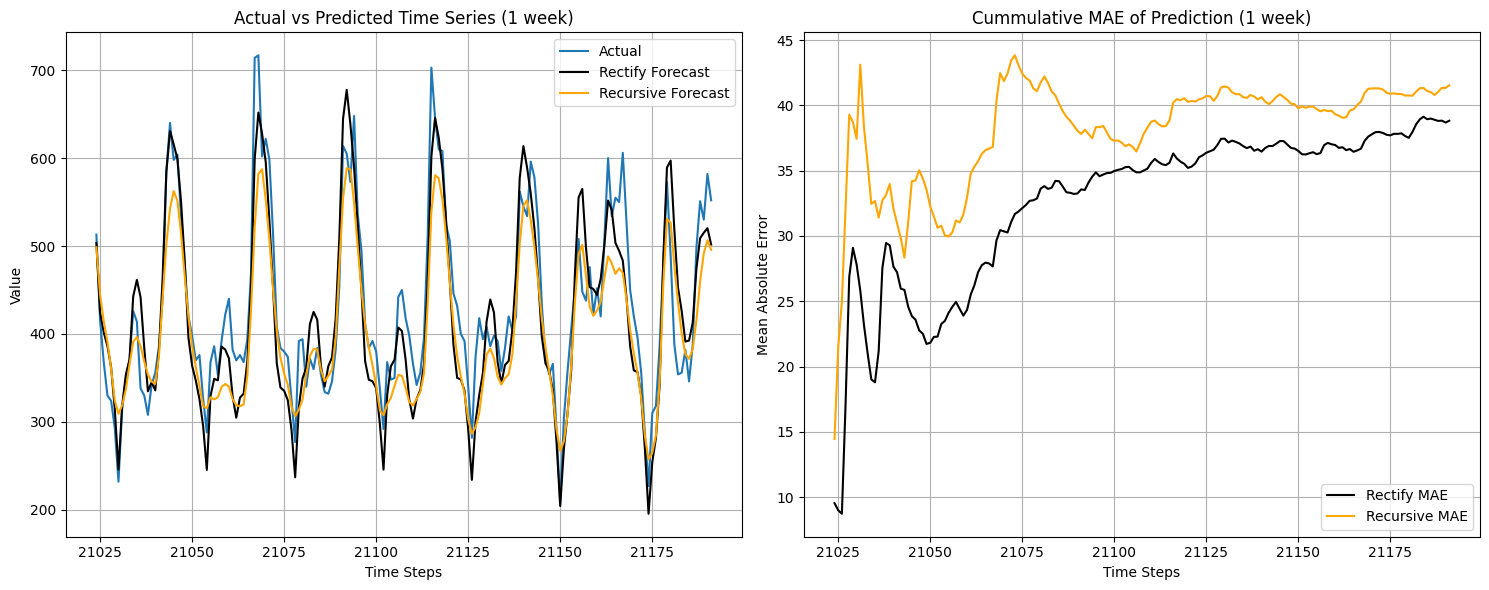

In [38]:
dts = window_size*1 # max timestep to plot until 
# dts = len(rectify)
# dts = len(series_valid)

fig, axs = plt.subplots(1, 2, sharey=False, figsize=(15,6))
axs[0].title.set_text('Actual vs Predicted Time Series (1 week)')
axs[0].set_ylabel('Value'); axs[0].set_xlabel('Time Steps')
axs[0].plot(time_valid[0:dts], series_valid[0:dts], label="Actual")
axs[0].plot(time_valid[0:dts], rectify[0:dts], 'k', label="Rectify Forecast")
axs[0].plot(time_valid[0:dts], recursive[0:dts], 'orange', label="Recursive Forecast")
axs[0].legend(); axs[0].grid()

axs[1].title.set_text('Cummulative MAE of Prediction (1 week)')
axs[1].set_ylabel('Mean Absolute Error'); axs[1].set_xlabel('Time Steps')
# axs[1].plot(time_valid[0:dts], rectify_absErr[0:dts], 'k', label="Absolute Error")
axs[1].plot(time_valid[0:dts], rectify_mae[0:dts], 'k', label="Rectify MAE")
axs[1].plot(time_valid[0:dts], recursive_mae[0:dts], 'orange', label="Recursive MAE")
axs[1].legend(); axs[1].grid()

fig.tight_layout()

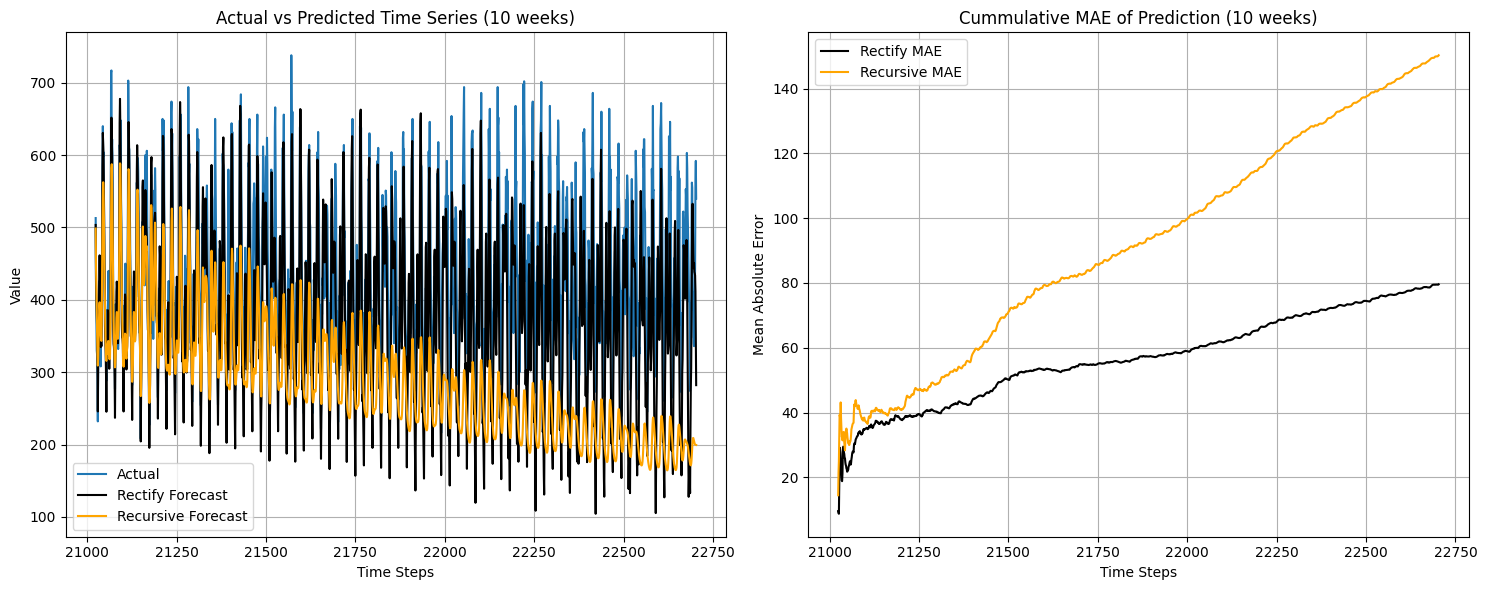

In [36]:
dts = window_size*10 # max timestep to plot until 
# dts = len(rectify)
# dts = len(series_valid)

fig, axs = plt.subplots(1, 2, sharey=False, figsize=(15,6))
axs[0].title.set_text('Actual vs Predicted Time Series (10 weeks)')
axs[0].set_ylabel('Value'); axs[0].set_xlabel('Time Steps')
axs[0].plot(time_valid[0:dts], series_valid[0:dts], label="Actual")
axs[0].plot(time_valid[0:dts], rectify[0:dts], 'k', label="Rectify Forecast")
axs[0].plot(time_valid[0:dts], recursive[0:dts], 'orange', label="Recursive Forecast")
axs[0].legend(); axs[0].grid()

axs[1].title.set_text('Cummulative MAE of Prediction (10 weeks)')
axs[1].set_ylabel('Mean Absolute Error'); axs[1].set_xlabel('Time Steps')
# axs[1].plot(time_valid[0:dts], rectify_absErr[0:dts], 'k', label="Absolute Error")
axs[1].plot(time_valid[0:dts], rectify_mae[0:dts], 'k', label="Rectify MAE")
axs[1].plot(time_valid[0:dts], recursive_mae[0:dts], 'orange', label="Recursive MAE")
axs[1].legend(); axs[1].grid()

fig.tight_layout()

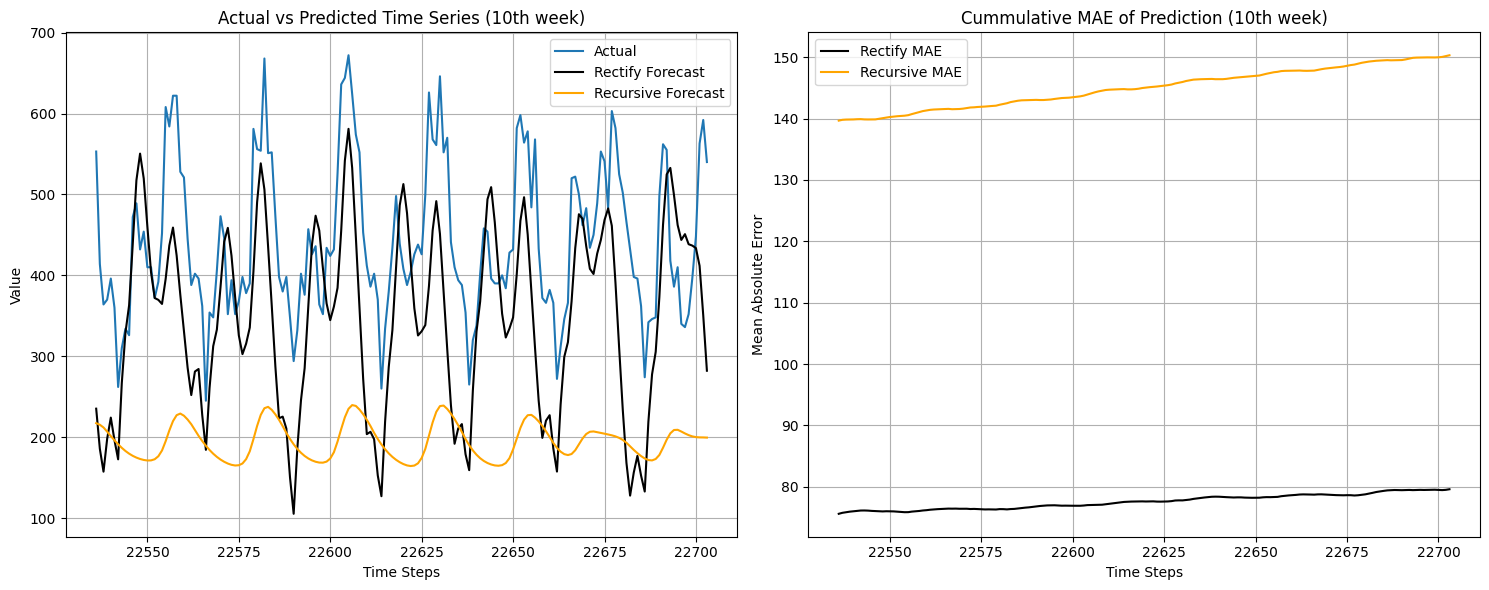

In [39]:
dts = window_size*1 # max timestep to plot until 
# dts = len(rectify)
# dts = len(series_valid)

fig, axs = plt.subplots(1, 2, sharey=False, figsize=(15,6))
axs[0].title.set_text('Actual vs Predicted Time Series (10th week)')
axs[0].set_ylabel('Value'); axs[0].set_xlabel('Time Steps')
axs[0].plot(time_valid[dts*9:dts*10], series_valid[dts*9:dts*10], label="Actual")
axs[0].plot(time_valid[dts*9:dts*10], rectify[dts*9:dts*10], 'k', label="Rectify Forecast")
axs[0].plot(time_valid[dts*9:dts*10], recursive[dts*9:dts*10], 'orange', label="Recursive Forecast")
axs[0].legend(); axs[0].grid()

axs[1].title.set_text('Cummulative MAE of Prediction (10th week)')
axs[1].set_ylabel('Mean Absolute Error'); axs[1].set_xlabel('Time Steps')
# axs[1].plot(time_valid[dts*9:dts*10], rectify_absErr[dts*9:dts*10], 'k', label="Absolute Error")
axs[1].plot(time_valid[dts*9:dts*10], rectify_mae[dts*9:dts*10], 'k', label="Rectify MAE")
axs[1].plot(time_valid[dts*9:dts*10], recursive_mae[dts*9:dts*10], 'orange', label="Recursive MAE")
axs[1].legend(); axs[1].grid()

fig.tight_layout()

# Implementing GAF into LSTNet

## Generating Windowed GAF

In [ ]:
def windowed_GAF_generator(series, window_size, stride):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + stride, shift=stride, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + stride))
    gasf = GramianAngularField(method='summation')
    
    gaf_outputs = []
    targets = []
    for window in dataset:
        window = window.numpy()
        window4gaf = window[:-stride]
        window_min = np.min(window4gaf)
        window_max = np.max(window4gaf)

        # This is to normalise the label between -1 and 1 as GAF inherently normalises the data to [-1,1]
        label = np.asarray([])
        for i in range(0,stride):
          d = (window[-stride+i] - window_max + window[-stride+i] - window_min) / (window_max - window_min)
          label = np.append(label,d)

        gaf_transformed = gasf.fit_transform(window4gaf.reshape(1, -1))
        gaf_outputs.append(tf.convert_to_tensor(gaf_transformed[0]))
        targets.append(tf.convert_to_tensor(label))

    return gaf_outputs, targets

In [ ]:
stride = 24
batch_size = 16
gaf_outputs, targets = windowed_GAF_generator(series_train, window_size, stride)
gaf_dataset = tf.data.Dataset.from_tensor_slices((gaf_outputs, targets))

In [ ]:
print(gaf_dataset.element_spec)

(TensorSpec(shape=(168, 168), dtype=tf.float64, name=None), TensorSpec(shape=(24,), dtype=tf.float64, name=None))


In [ ]:
# Apply batching on the GAF dataset
gaf_dataset = gaf_dataset.batch(batch_size).prefetch(1)
# Shuffle the dataset
gaf_dataset = gaf_dataset.shuffle(shuffle_buffer_size)

## Windowed GAF input statistics

In [ ]:
for windows in gaf_dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}')
  print(f'shape of second element: {windows[1].shape}')

total_elements = 0
for _ in gaf_dataset:
    total_elements += 1
print("Total elements in the dataset:", total_elements)

data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (16, 168, 168)
shape of second element: (16, 24)
Total elements in the dataset: 55


In [ ]:
# Extract the first GAF-transformed window and target value
first_gaf_window, first_target = next(iter(gaf_dataset))

# Convert the tensors to numpy arrays
first_gaf_window_np = first_gaf_window.numpy()
first_target_np = first_target.numpy()

# print("First GAF-transformed window:")
# print(first_gaf_window)
# print("\nFirst target value:", first_target_np)

In [ ]:
total_elements = 0
for _ in gaf_dataset:
    total_elements += 1
print("Total elements in the dataset:", total_elements)

Total elements in the dataset: 55


In [ ]:
# Print properties of a single batch
print("Properties of a single batch:")
print("------------------------------")
for windows in gaf_dataset.take(1):
  print(f'data type: {type(windows)}')
  print(f'number of elements in the tuple: {len(windows)}')
  print(f'shape of first element: {windows[0].shape}') # (batch_size, window_size)
  print(f'shape of second element: {windows[1].shape}') # (batch_size, )

Properties of a single batch:
------------------------------
data type: <class 'tuple'>
number of elements in the tuple: 2
shape of first element: (16, 168, 168)
shape of second element: (16, 24)


## LSTNet-GAF Main Architecture

In [ ]:
def build_fn(n_targets, # Number of time series. (int)
             n_pred,
             n_lookback, # Number of past time steps to use as input. (int)
             filters, # Number of filters (or channels) of the convolutional layer. (int)
             kernel_size, # Kernel size of the convolutional layer. (int)
             gru_units, # Hidden units of GRU layer. (list)
             skip_gru_units, # Hidden units of Skip GRU layer. (list)
             skip, # Number of skipped hidden cells in the Skip GRU layer. (int)
             lags, # Number of autoregressive lags. (int)
             num_heads, # Number of attention heads. (int) <---- NEW!
             dropout, # Dropout rate. (float)
             regularizer, # Regularizer, either 'L1', 'L2' or 'L1L2'. (str)
             regularization_factor): # Regularization factor. (float)

    # # Inputs.
    # x = tf.keras.layers.Input(shape=(n_lookback, n_targets))

    # # Convolutional component, see Section 3.2 in the LSTNet paper.
    # c = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
    # c = tf.keras.layers.Dropout(rate=dropout)(c)

    # Inputs (MODIFIED)
    x = tf.keras.layers.Input(shape=(n_lookback, n_lookback, n_targets))

    # Convolutional component, see Section 3.2 in the LSTNet paper. (MODIFIED)
    c = tf.keras.layers.Conv2D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Conv2D(filters=filters*2, kernel_size=kernel_size, activation='relu')(c)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Conv2D(filters=filters*3, kernel_size=kernel_size, activation='relu')(c)
    c = tf.keras.layers.MaxPooling2D(2, 2)(c)
    c = tf.keras.layers.Dropout(rate=dropout)(c)
    c = tf.keras.layers.Reshape((-1, c.shape[1] * c.shape[2] * c.shape[3]))(c)

    # Recurrent component, see Section 3.3 in the LSTNet paper.
    r = tf.keras.layers.GRU(units=gru_units, activation='relu', return_sequences=True)(c)
    
    # Attention Mechanism, see Section 3.5 in the LSTNet paper. <---- NEW!
    r = MultiHeadAttention(num_heads=num_heads, key_dim=gru_units)(r, r)
    r = tf.keras.layers.Flatten()(r)
    r = tf.keras.layers.Dropout(rate=dropout)(r)
    
    # Recurrent-skip component, see Section 3.4 in the LSTNet paper.
    s = SkipGRU(units=skip_gru_units, activation='relu', return_sequences=True)(c)
    s = tf.keras.layers.Dropout(rate=dropout)(s)
    s = tf.keras.layers.Lambda(function=lambda x: x[:, - skip:, :])(s)
    s = tf.keras.layers.Reshape(target_shape=(s.shape[1] * s.shape[2],))(s)
    d = tf.keras.layers.Concatenate(axis=1)([r, s])
    d = tf.keras.layers.Dense(units=n_targets, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(d)

    # Autoregressive component, see Section 3.6 in the LSTNet paper.
    l = tf.keras.layers.Flatten()(x[:, - lags:, :])
    l = tf.keras.layers.Dense(units=n_pred, kernel_regularizer=kernel_regularizer(regularizer, regularization_factor))(l)

    # Outputs.
    y = tf.keras.layers.Add()([d, l])

    return tf.keras.models.Model(x, y)

## LSTNet-GAF Training Parameters

In [ ]:
# Build and save LSTNet Model
model_gaf = build_fn(
            n_targets = 1, # univariate time series test
            n_pred = stride,
            n_lookback = window_size,
            filters = 64,
            kernel_size = 3,
            gru_units = 100,
            skip_gru_units = 50,
            skip = 1,
            lags = 1,
            num_heads = 2,
            dropout = 0,
            regularizer = 'L2',
            regularization_factor = 0.01)

In [ ]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model_gaf.set_weights(tf.keras.models.clone_model(model_gaf).get_weights())

# Set the learning rate
# learning_rate = 0.01 #7.0795e-06 # optimal from Tuning Process (loss minimized)
epochs = 10
initial_learning_rate = 0.01
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = total_elements
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)

# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Adam optimizer appears to run quite slowly
# optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model_gaf.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model_gaf.fit(gaf_dataset,epochs=epochs)
# model_gaf.save("model_gaf.h5")

Epoch 1/10
55/55 [==============================] - 120s 2s/step - loss: 22.6811 - mae: 22.7029
Epoch 2/10
55/55 [==============================] - 105s 2s/step - loss: 0.1274 - mae: 0.2079
Epoch 3/10
55/55 [==============================] - 102s 2s/step - loss: 0.0671 - mae: 0.1804
Epoch 4/10
55/55 [==============================] - 103s 2s/step - loss: 0.0501 - mae: 0.1751
Epoch 5/10
55/55 [==============================] - 101s 2s/step - loss: 0.0432 - mae: 0.1710
Epoch 6/10
55/55 [==============================] - 102s 2s/step - loss: 0.0399 - mae: 0.1670
Epoch 7/10
55/55 [==============================] - 102s 2s/step - loss: 0.0375 - mae: 0.1620
Epoch 8/10
55/55 [==============================] - 101s 2s/step - loss: 0.0366 - mae: 0.1619
Epoch 9/10
55/55 [==============================] - 102s 2s/step - loss: 0.0360 - mae: 0.1611
Epoch 10/10
55/55 [==============================] - 102s 2s/step - loss: 0.0356 - mae: 0.1605


In [ ]:
# model_gaf = keras.models.load_model("model_gaf.h5")

## LSTNet-GAF Recursive Forecast

In [ ]:
def recursive_forecast_gaf(model, series, window_size, stride, hsteps):
  window = series[-window_size:]
  gasf = GramianAngularField(method='summation')
  forecast = []
  for h in range(int(hsteps/stride)):
    window_min = np.min(window)
    window_max = np.max(window)

    window_transformed = gasf.fit_transform(window.reshape(1, -1))
    nextstep = model_gaf.predict(window_transformed,verbose=0).squeeze()
    for i in range(len(nextstep)):
      value = (nextstep[i]*(window_max - window_min) + window_max + window_min)*0.5
      window = np.append(window,value) #add next n step to window
      forecast = np.append(forecast,value)
    window = window[len(nextstep):] #delete first n step of window
    
  return forecast   

In [ ]:
recursive_gaf = recursive_forecast_gaf(model_gaf, series_train, window_size, stride, window_size*20) # 11min len(series_valid)
np.save('recursive_gaf_result', recursive)

In [ ]:
recursive_gaf = np.load('recursive_gaf_result.npy')

# Absolute Error vs Time
recursive_gaf_absErr = abs(np.subtract(recursive_gaf,series_valid[0:len(recursive)]))

# Mean Absolute Error vs Time
recursive_gaf_mae = np.asarray([ recursive_gaf_absErr[0] , (recursive_gaf_absErr[0]+recursive_gaf_absErr[1])/2 ])
for i in range(len(recursive_gaf_absErr)-2):
  CummErr = recursive_gaf_mae[-1]*(i+1) 
  mae = (CummErr + recursive_gaf_absErr[i+1]) / (i+2)
  recursive_gaf_mae = np.append(recursive_gaf_mae,mae)

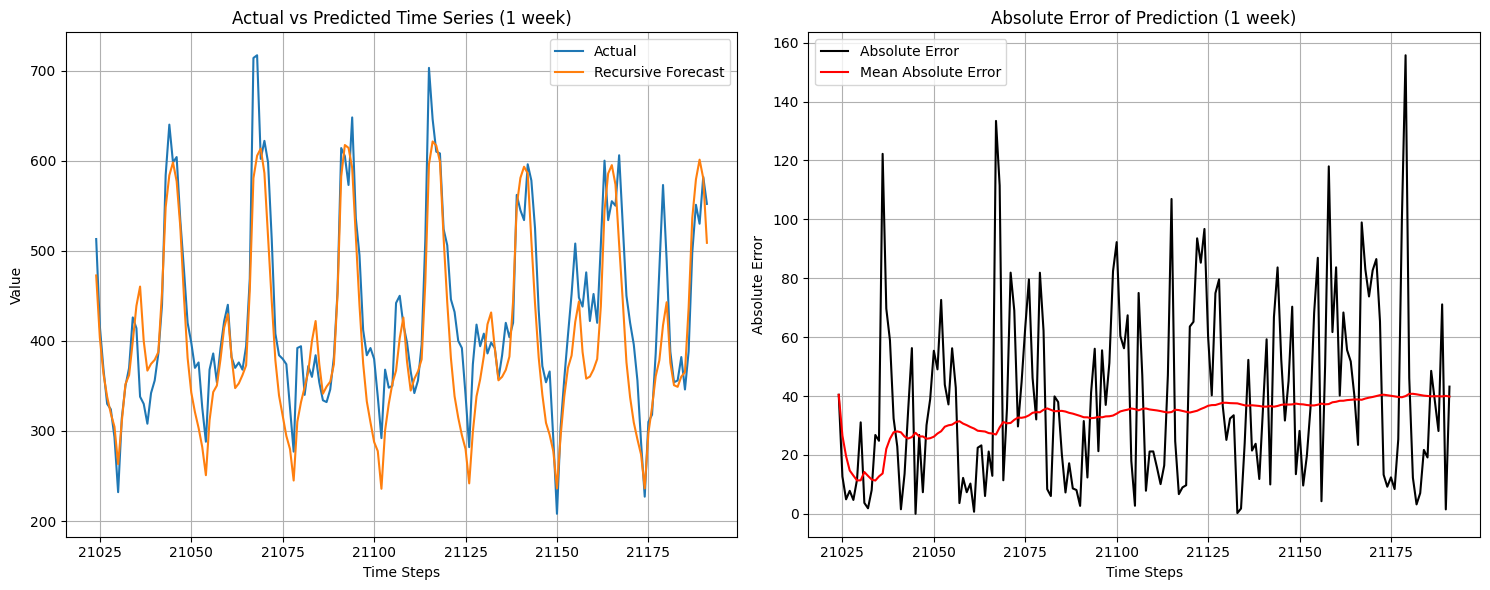

In [ ]:
dts = window_size # max timestep to plot until 
# dts = len(recursive)
# dts = len(series_valid)

fig, axs = plt.subplots(1, 2, sharey=False, figsize=(15,6))
axs[0].title.set_text('Actual vs Predicted Time Series (1 week)')
axs[0].set_ylabel('Value'); axs[0].set_xlabel('Time Steps')
axs[0].plot(time_valid[0:dts], series_valid[0:dts], label="Actual")
axs[0].plot(time_valid[0:dts], recursive_gaf[0:dts], label="Recursive_gaf Forecast")
axs[0].legend(); axs[0].grid()

axs[1].title.set_text('Absolute Error of Prediction (1 week)')
axs[1].set_ylabel('Absolute Error'); axs[1].set_xlabel('Time Steps')
axs[1].plot(time_valid[0:dts], recursive_gaf_absErr[0:dts], 'k', label="Absolute Error")
axs[1].plot(time_valid[0:dts], recursive_gaf_mae[0:dts], 'r', label="Mean Absolute Error")
axs[1].legend(); axs[1].grid()

fig.tight_layout()

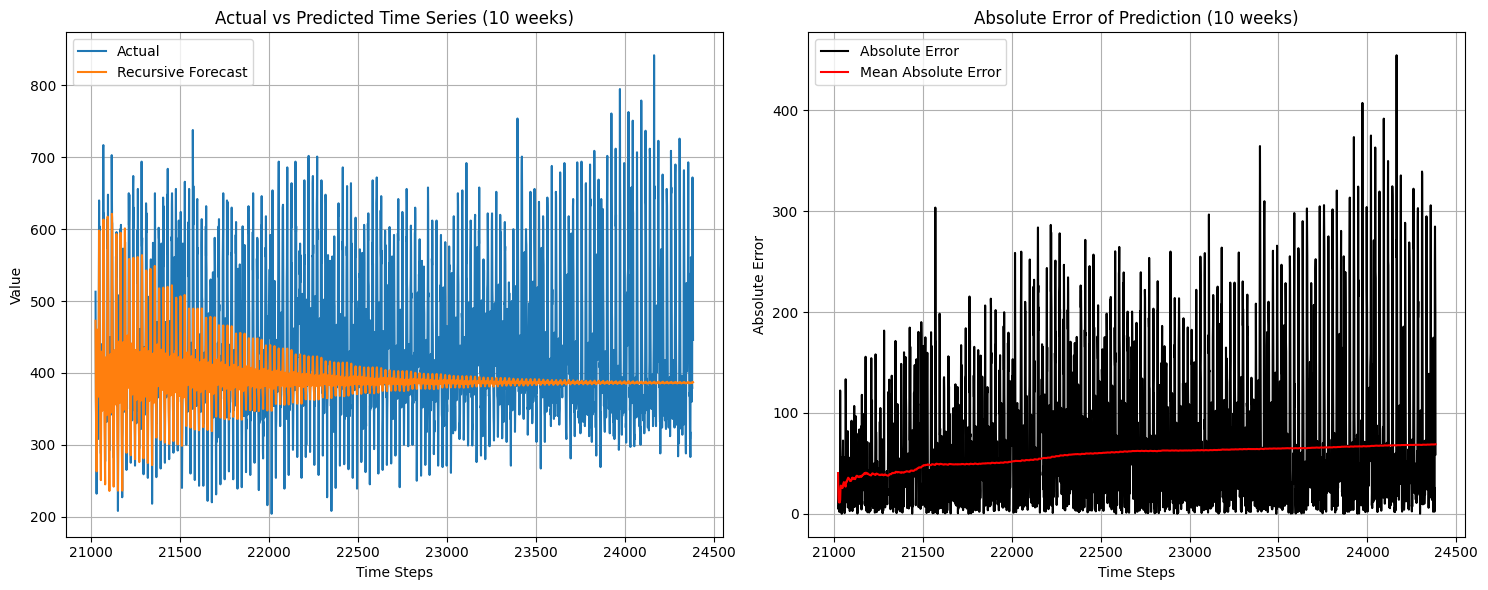

In [ ]:
dts = window_size*10 # max timestep to plot until 
dts = len(recursive)
# dts = len(series_valid)

fig, axs = plt.subplots(1, 2, sharey=False, figsize=(15,6))
axs[0].title.set_text('Actual vs Predicted Time Series (10 weeks)')
axs[0].set_ylabel('Value'); axs[0].set_xlabel('Time Steps')
axs[0].plot(time_valid[0:dts], series_valid[0:dts], label="Actual")
axs[0].plot(time_valid[0:dts], recursive_gaf[0:dts], label="Recursive_gaf Forecast")
axs[0].legend(); axs[0].grid()

axs[1].title.set_text('Absolute Error of Prediction (10 weeks)')
axs[1].set_ylabel('Absolute Error'); axs[1].set_xlabel('Time Steps')
axs[1].plot(time_valid[0:dts], recursive_gaf_absErr[0:dts], 'k', label="Absolute Error")
axs[1].plot(time_valid[0:dts], recursive_gaf_mae[0:dts], 'r', label="Mean Absolute Error")
axs[1].legend(); axs[1].grid()

fig.tight_layout()

## LSTNet-GAF Rectify Forecast

In [ ]:
num_windows = int((split_time-window_size*2)/stride)
window = series_train[0:window_size]
forecast_train = []
for i in tqdm(range(1,num_windows)):
  value = recursive_forecast_gaf(model_gaf, window, window_size, stride, stride)
  forecast_train = np.append(forecast_train,value)
  window = series_train[ stride*i+window_size : stride*i+window_size*2]

100%|██████████| 861/861 [01:30<00:00,  9.54it/s]


In [ ]:
actual_train = series_train[window_size:len(forecast_train)+window_size]
actual_train_time = time_train[window_size:len(forecast_train)+window_size]
error_train = actual_train - forecast_train
actual_train = series_train[0:len(forecast_train)]

In [ ]:
def windowed_GAF_generator_error(series, window_size, stride, error_series, error_min, error_max):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size, shift=stride, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    gasf = GramianAngularField(method='summation')

    gaf_outputs = []
    targets = []
    win_num = 0
    for window in dataset:
        window = window.numpy()

        # This is to normalise the label between -1 and 1 as GAF inherently normalises the data to [-1,1]
        label = np.asarray([])
        for i in range(0,stride):
          d = (error_series[i+win_num*stride] - error_max + error_series[i+win_num*stride] - error_min) / (error_max - error_min)
          label = np.append(label,d)

        gaf_transformed = gasf.fit_transform(window.reshape(1, -1))
        gaf_outputs.append(tf.convert_to_tensor(gaf_transformed[0]))
        targets.append(tf.convert_to_tensor(label))
        win_num = win_num + 1

    return gaf_outputs, targets

In [ ]:
error_min = np.min(error_train)
error_max = np.max(error_train)
gaf_outputs, targets = windowed_GAF_generator_error(actual_train, window_size, stride, error_train, error_min, error_max)
gaf_dataset = tf.data.Dataset.from_tensor_slices((gaf_outputs, targets))

In [ ]:
print(gaf_dataset.element_spec)

(TensorSpec(shape=(168, 168), dtype=tf.float64, name=None), TensorSpec(shape=(24,), dtype=tf.float64, name=None))


In [ ]:
# Apply batching on the GAF dataset
gaf_dataset = gaf_dataset.batch(batch_size).prefetch(1)
# Shuffle the dataset
gaf_dataset = gaf_dataset.shuffle(shuffle_buffer_size)

In [ ]:
total_elements = 0
for _ in gaf_dataset:
    total_elements += 1
print("Total elements in the dataset:", total_elements)

Total elements in the dataset: 54


In [ ]:
# Build and save LSTNet Model
model_gaf_error = build_fn(
    n_targets = 1, # univariate time series test
    n_pred = stride,
    n_lookback = window_size,
    filters = 64,
    kernel_size = 3,
    gru_units = 100,
    skip_gru_units = 50,
    skip = 1,
    lags = 1,
    num_heads = 2,
    dropout = 0,
    regularizer = 'L2',
    regularization_factor = 0.01)
# Reset states generated by Keras
tf.keras.backend.clear_session()
# Reset the weights
model_gaf_error.set_weights(tf.keras.models.clone_model(model_gaf_error).get_weights())
# Set the learning rate
epochs = 15
initial_learning_rate = 0.01
final_learning_rate = 0.0001
learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
steps_per_epoch = total_elements
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
                initial_learning_rate=initial_learning_rate,
                decay_steps=steps_per_epoch,
                decay_rate=learning_rate_decay_factor,
                staircase=True)
# Set the optimizer 
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate) # Adam optimizer appears to run quite slowly
# optimizer = tf.keras.optimizers.SGD(learning_rate = learning_rate, momentum = 0.9)

# Set the training parameters
model_gaf_error.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

# Train the model
history = model_gaf_error.fit(gaf_dataset,epochs=epochs)
# model_gaf_error.save("model_gaf_error.h5")

Epoch 1/15
54/54 [==============================] - 103s 2s/step - loss: 32.9966 - mae: 33.0096
Epoch 2/15
54/54 [==============================] - 95s 2s/step - loss: 0.1299 - mae: 0.1645
Epoch 3/15
54/54 [==============================] - 95s 2s/step - loss: 0.0547 - mae: 0.1330
Epoch 4/15
54/54 [==============================] - 96s 2s/step - loss: 0.0312 - mae: 0.1223
Epoch 5/15
54/54 [==============================] - 97s 2s/step - loss: 0.0231 - mae: 0.1164
Epoch 6/15
54/54 [==============================] - 96s 2s/step - loss: 0.0198 - mae: 0.1142
Epoch 7/15
54/54 [==============================] - 97s 2s/step - loss: 0.0183 - mae: 0.1116
Epoch 8/15
54/54 [==============================] - 97s 2s/step - loss: 0.0173 - mae: 0.1096
Epoch 9/15
54/54 [==============================] - 98s 2s/step - loss: 0.0168 - mae: 0.1083
Epoch 10/15
54/54 [==============================] - 97s 2s/step - loss: 0.0164 - mae: 0.1077
Epoch 11/15
54/54 [==============================] - 98s 2s/step -

In [ ]:
# model.save("model_gaf_error.h5")

In [ ]:
def rectify_forecast_gaf(model, error_model, series, window_size, stride, hsteps, error_min, error_max):
  window = series[-window_size:]
  gasf = GramianAngularField(method='summation')
  forecast = []
  for h in tqdm(range(int(hsteps/stride))):
    window_min = np.min(window)
    window_max = np.max(window)

    window_transformed = gasf.fit_transform(window.reshape(1, -1))
    nextstep = model.predict(window_transformed,verbose=0).squeeze()
    nexterror = error_model.predict(window_transformed,verbose=0).squeeze()
    for i in range(len(nextstep)):
      value = (nextstep[i]*(window_max - window_min) + window_max + window_min)*0.5
      error = (nexterror[i]*(error_max - error_min) + error_max + error_min)*0.5
      window = np.append(window,value+error) #add next n step to window
      forecast = np.append(forecast,value+error)
    window = window[len(nextstep):] #delete first n step of window
    
  return forecast   

In [ ]:
rectify_gaf = rectify_forecast_gaf(model_gaf, model_gaf_error, series_train, window_size, stride, len(series_valid), error_min, error_max)
np.save('rectify_gaf_result', rectify)

100%|██████████| 220/220 [00:45<00:00,  4.87it/s]


In [ ]:
rectify_gaf = np.load('rectify_gaf_result.npy')

# Absolute Error vs Time
rectify_gaf_absErr = abs(np.subtract(rectify_gaf,series_valid[0:len(rectify_gaf)]))

# Mean Absolute Error vs Time
rectify_gaf_mae = np.asarray([ rectify_gaf_absErr[0] , (rectify_gaf_absErr[0]+rectify_gaf_absErr[1])/2 ])
for i in range(len(rectify_gaf_absErr)-2):
  CummErr = rectify_gaf_mae[-1]*(i+1) 
  mae = (CummErr + rectify_gaf_absErr[i+1]) / (i+2)
  rectify_gaf_mae = np.append(rectify_gaf_mae,mae)

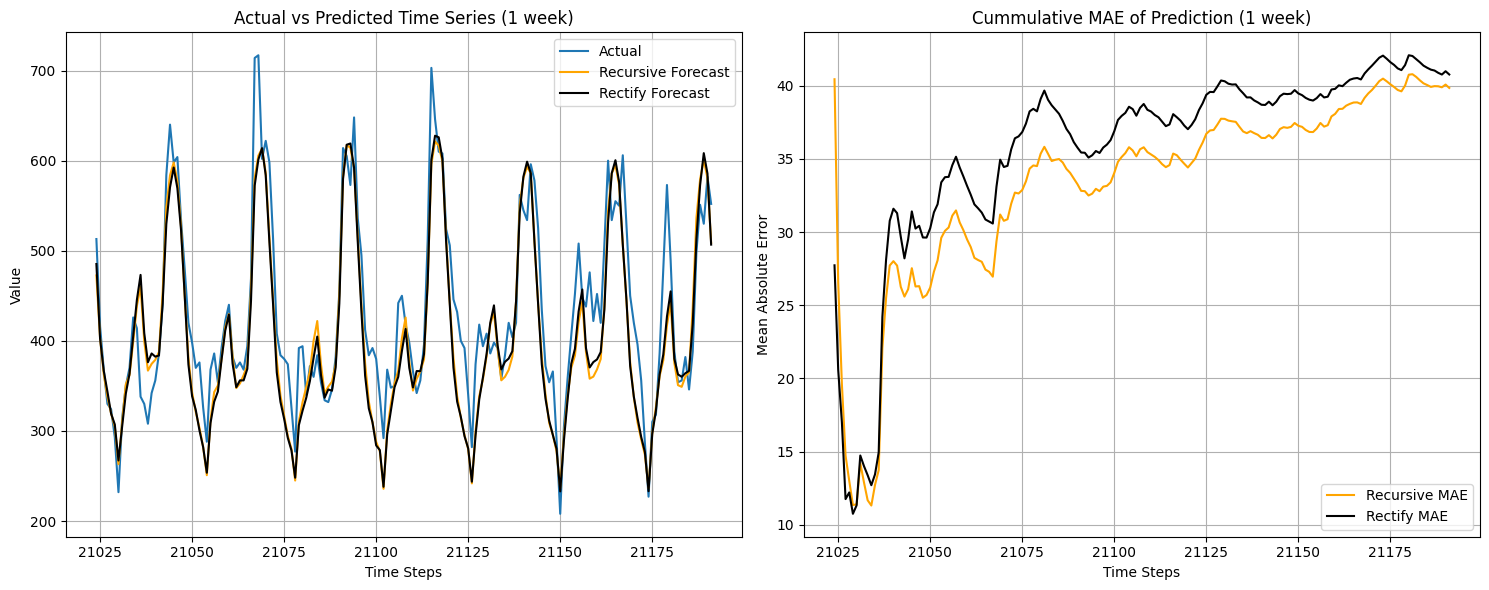

In [ ]:
dts = window_size*1 # max timestep to plot until 
# dts = len(rectify_gaf)
# dts = len(series_valid)

fig, axs = plt.subplots(1, 2, sharey=False, figsize=(15,6))
axs[0].title.set_text('Actual vs Predicted Time Series (1 week)')
axs[0].set_ylabel('Value'); axs[0].set_xlabel('Time Steps')
axs[0].plot(time_valid[0:dts], series_valid[0:dts], label="Actual")
axs[0].plot(time_valid[0:dts], recursive_gaf[0:dts], 'orange', label="Recursive_gaf Forecast")
axs[0].plot(time_valid[0:dts], rectify_gaf[0:dts], 'k', label="Rectify_gaf Forecast")
axs[0].legend(); axs[0].grid()

axs[1].title.set_text('Cummulative MAE of Prediction (1 week)')
axs[1].set_ylabel('Mean Absolute Error'); axs[1].set_xlabel('Time Steps')
# axs[1].plot(time_valid[0:dts], rectify_absErr[0:dts], 'k', label="Absolute Error")
axs[1].plot(time_valid[0:dts], recursive_gaf_mae[0:dts], 'orange', label="Recursive_gaf MAE")
axs[1].plot(time_valid[0:dts], rectify_gaf_mae[0:dts], 'k', label="Rectify_gaf MAE")
axs[1].legend(); axs[1].grid()

fig.tight_layout()

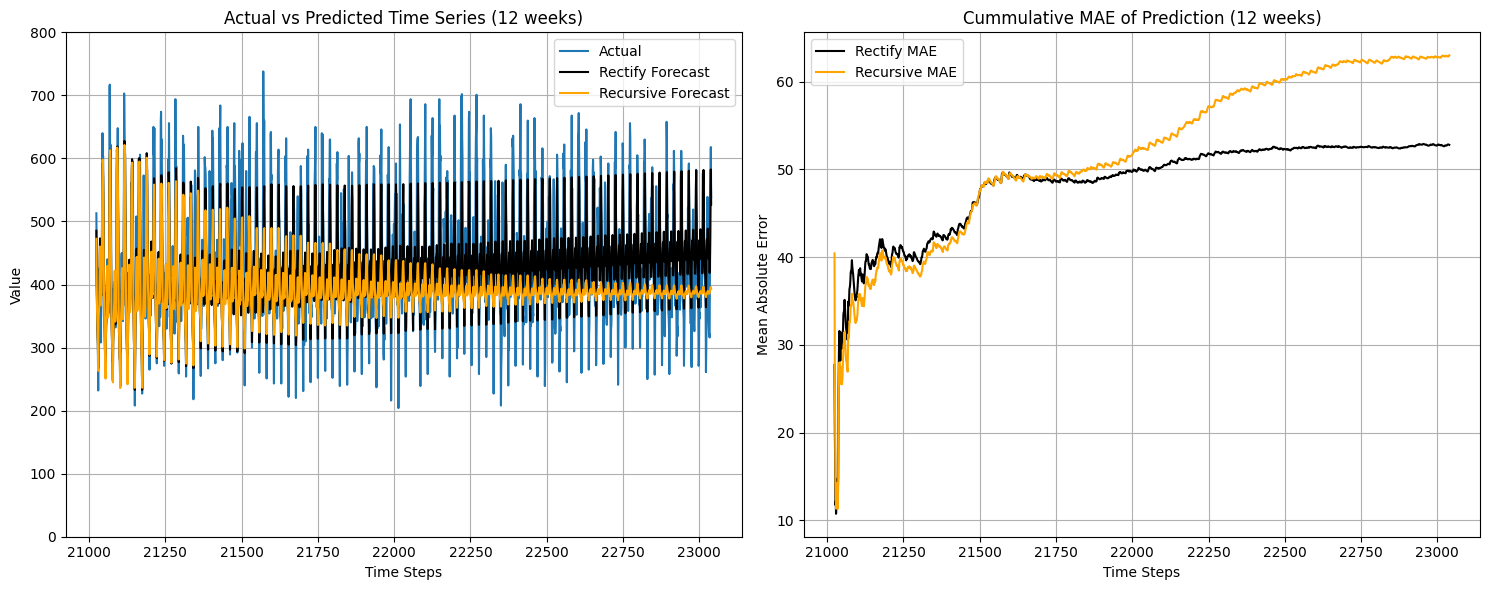

In [ ]:
dts = window_size*12 # max timestep to plot until 
# dts = len(rectify_gaf)
# dts = len(series_valid)

fig, axs = plt.subplots(1, 2, sharey=False, figsize=(15,6))
axs[0].title.set_text('Actual vs Predicted Time Series (12 weeks)')
axs[0].set_ylabel('Value'); axs[0].set_xlabel('Time Steps')
axs[0].plot(time_valid[0:dts], series_valid[0:dts], label="Actual")
axs[0].plot(time_valid[0:dts], rectify_gaf[0:dts], 'k', label="Rectify_gaf Forecast")
axs[0].plot(time_valid[0:dts], recursive_gaf[0:dts], 'orange', label="Recursiv_gaf Forecast")
axs[0].set_ylim([0, 800])
axs[0].legend(); axs[0].grid()

axs[1].title.set_text('Cummulative MAE of Prediction (12 weeks)')
axs[1].set_ylabel('Mean Absolute Error'); axs[1].set_xlabel('Time Steps')
# axs[1].plot(time_valid[0:dts], rectify_gaf_absErr[0:dts], 'k', label="Absolute Error")
axs[1].plot(time_valid[0:dts], rectify_gaf_mae[0:dts], 'k', label="Rectify_gaf MAE")
axs[1].plot(time_valid[0:dts], recursive_gaf_mae[0:dts], 'orange', label="Recursive_gaf MAE")
axs[1].legend(); axs[1].grid()

fig.tight_layout()